In [1]:
import tensorboard
import tensorflow as tf
import keras 
import tensorflow_hub as hub
import tensorflow_text
import pandas as pd

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import numpy as np

In [3]:
#The dataset is Standford Sentiment Treebank (SST-2) dataset
# https://nlp.stanford.edu/sentiment/index.html
# 
# The dataset contains sentences from movie reviews and human annotations of their sentiment.
# 
# The task is to predict the sentiment of a given sentence.
# 
# The sentences are annotated on a scale of five values: very negative, negative, neutral, positive, very positive.

dictionary = pd.read_csv('Data/stanfordSentimentTreebank/dictionary.txt', sep='|')
#sentiment_labels is a txt file with the sentiment labels
sentiment_labels = pd.read_csv('Data/stanfordSentimentTreebank/sentiment_labels.txt', sep='|')

In [4]:
#merge the dictionary and sentiment_labels
datasetMindsetEval = dictionary.merge(sentiment_labels, on='phrase_index')
#convert into a dataframe
datasetMindsetEval = pd.DataFrame(datasetMindsetEval)

In [5]:
#if sentiment socre is larger than 0.6, then the sentiment is positive
#if sentiment socre is smaller than 0.4, then the sentiment is negative
#if sentiment socre is between 0.4 and 0.6, then the sentiment is neutral
datasetMindsetEval['label'] = datasetMindsetEval['sentiment values'].apply(lambda x: 'positive' if x > 0.6 else ('negative' if x < 0.4 else 'neutral'))

In [6]:
data = datasetMindsetEval

In [7]:
from sklearn.preprocessing import LabelBinarizer
encoderNew = LabelBinarizer()
transfomed_label = encoderNew.fit_transform(data['label'])
data['label'] = transfomed_label

# Save the encoder classes for later use
np.save('./Models/encoder.npy', encoderNew.classes_)

In [8]:
# data preprocessing
data['sentence'] = data['sentence'].apply(lambda x: x.lower())
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\n', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\t', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\r', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\xa0', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\u200b', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\ufeff', ' '))

In [9]:
#split the dataset into train, validation and test
train_dataset = datasetMindsetEval.sample(frac=0.8, random_state=0)
test_dataset = datasetMindsetEval.drop(train_dataset.index)
validation_dataset = test_dataset.sample(frac=0.5, random_state=0)
test_dataset = test_dataset.drop(validation_dataset.index)

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_dataset['sentence'], train_dataset['label']))

In [11]:
val_ds = tf.data.Dataset.from_tensor_slices((validation_dataset['sentence'], validation_dataset['label']))

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 59

train_ds = train_ds.shuffle(buffer_size=len(data)).batch(batch_size)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.shuffle(buffer_size=len(val_ds)).batch(batch_size)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
tfhub_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
tfhub_prepocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"


In [15]:
# create the deep learning model to classify text into three categories
text_input = keras.Input(shape=(), dtype='string', name='text_input')
preprocessing_layer = hub.KerasLayer(tfhub_prepocess, name='Preprocessing_for_BERT')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_encoder, trainable=False, name='BERT_encoder')
outputs = encoder(encoder_inputs)
x = keras.layers.Dropout(0.3)(outputs['sequence_output'])
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
#x = keras.layers.Dense(20, activation='relu')(x)
#x = keras.layers.Dropout(0.35)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs=[text_input], outputs=x)
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',             
                metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Preprocessing_for_BERT (KerasL  {'input_word_ids':   0          ['text_input[0][0]']             
 ayer)                          (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [16]:
from tensorflow.keras.callbacks import TensorBoard
import time

# logs about the training process
# accuracy and loss are plotted in the TensorBoard
log_dir = "logs/fit/" + str(int(time.time()))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:
epochs = 50
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[
                        keras.callbacks.TensorBoard("logs/fit/" + str(int(time.time())),
                                                    histogram_freq=1,
                                                    write_graph=True,
                                                    write_images=True),
                        keras.callbacks.EarlyStopping(patience=5,
                                                      monitor='val_loss')

                    ])


Epoch 1/50
5981/5981 [==============================] - 2457s 409ms/step - loss: 0.3563 - accuracy: 0.8368 - val_loss: 0.3420 - val_accuracy: 0.8488
Epoch 2/50
5981/5981 [==============================] - 2409s 403ms/step - loss: 0.3342 - accuracy: 0.8484 - val_loss: 0.3370 - val_accuracy: 0.8537
Epoch 3/50
5981/5981 [==============================] - 2418s 404ms/step - loss: 0.3239 - accuracy: 0.8537 - val_loss: 0.3334 - val_accuracy: 0.8563
Epoch 4/50
5981/5981 [==============================] - 2433s 407ms/step - loss: 0.3164 - accuracy: 0.8576 - val_loss: 0.3279 - val_accuracy: 0.8566
Epoch 5/50
5981/5981 [==============================] - 2458s 411ms/step - loss: 0.3098 - accuracy: 0.8612 - val_loss: 0.3273 - val_accuracy: 0.8586
Epoch 6/50
5981/5981 [==============================] - 2448s 409ms/step - loss: 0.3036 - accuracy: 0.8641 - val_loss: 0.3266 - val_accuracy: 0.8601
Epoch 7/50
5981/5981 [==============================] - 2428s 406ms/step - loss: 0.2991 - accuracy: 0.8666

In [18]:
test_ds = tf.data.Dataset.from_tensor_slices((test_dataset['sentence'], test_dataset['label']))

In [19]:
# create the test dataset
test_ds = test_ds.shuffle(buffer_size=len(test_ds)).batch(batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# evaluate the model
results = model.evaluate(test_ds, verbose=1, callbacks=[
    keras.callbacks.TensorBoard(log_dir='./logs',
                                histogram_freq=1,
                                write_graph=True,
                                write_images=True)]
)


# print the results
print('Test loss:', results[0])
print('Test accuracy:', results[1])

748/748 [==============================] - 418s 556ms/step - loss: 0.3289 - accuracy: 0.8583
Test loss: 0.32894641160964966
Test accuracy: 0.8582953810691833


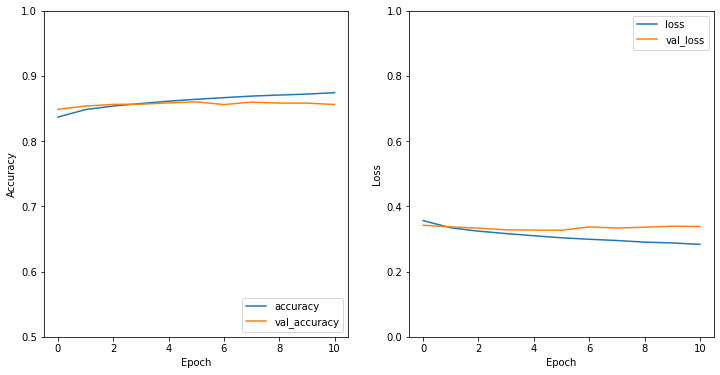

In [20]:
#draw the accuracy and loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.ylim([0, 1])
plt.show()



In [21]:
# Test Model with Sample Test Data
text = 'There were members who do not contribute for the projects. Actually I do not prefer to work with a team'


# get prdiction from the model
prediction = model.predict([text])

In [23]:
encoderNew.inverse_transform(prediction)

array(['neutral'], dtype='<U8')

In [24]:
#model name with date and time
model_name = 'model_' + str(int(time.time()))

# save the model
model.save(model_name + '.h5')

In [25]:
#save the model
model.save('./Models/' + model_name)

INFO:tensorflow:Assets written to: ./Models/model_1665302784\assets


INFO:tensorflow:Assets written to: ./Models/model_1665302784\assets


In [26]:
# load the model
model = keras.models.load_model('./Models/' + model_name)

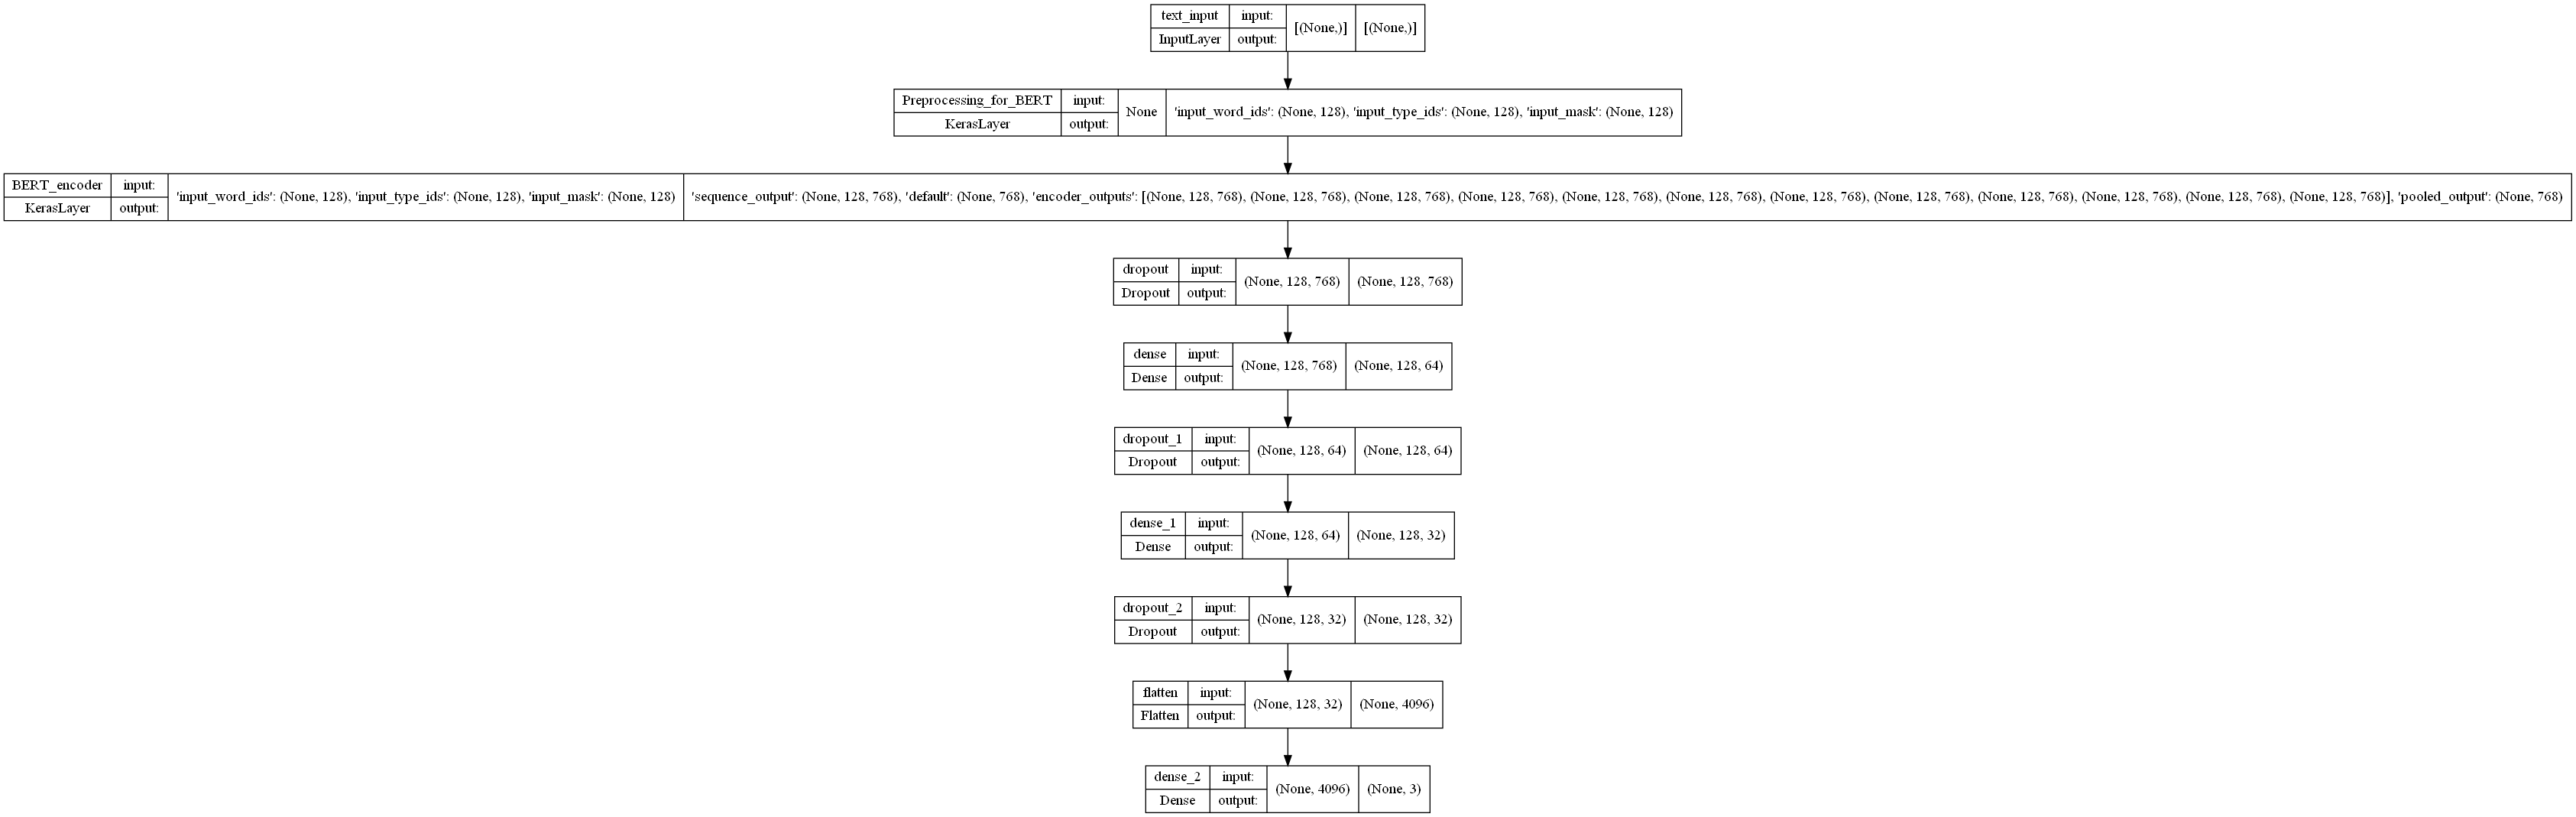

In [28]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./Model Output/' + model_name + '.png', show_shapes=True, show_layer_names=True)

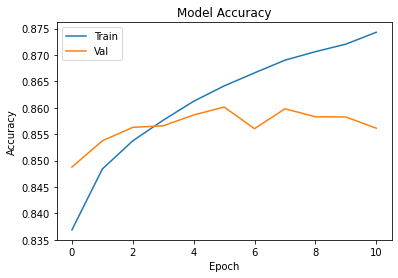

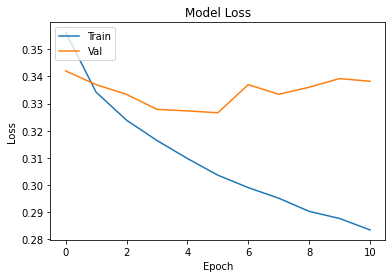

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()